# **MIDTERM PROJECT**
# **Forecasting Net Sales Amount of SITD using Time Series Models**

**1. Introduction**

In financial management, especially in securities firms, forecasting short-term cash flow is critical for budgeting and planning. This project utilizes historical sales data from SITD to forecast Net Sales Amount, the net value of securities sold after returns over the next 30 days.

The core objective is to apply time series models to learn from past patterns and generate accurate short-term forecasts. Such forecasting supports the company in managing liquidity and reducing risks due to unexpected fluctuations.

**2. Dataset and Preprocessing**

*2.1. Dataset Overview*

The Electronic Securities Transactions dataset details how many of each type of Treasury bonds are issued, redeemed, or outstanding from Fiscal Year (FY) 2002 until present. Outstanding bonds refer to those which are still in circulation, and have not yet been redeemed. The number of outstanding Treasury bonds is determined by taking the difference between the numbers of Treasury bonds issued and redeemed. This dataset does not contain any information on the values or yields of the Treasury bonds.


Time period: July 1, 2020 – June 30, 2025

Observations: 298 rows

Target variable: Net Sales Amount

Other features: Number of securities sold, Gross/Returned Sales, and calendar features (year, quarter, month, day)

*2.2. Preprocessing Steps*

Date Parsing: Converted Record Date into datetime format and sorted chronologically

Daily Aggregation: Grouped data by date using .groupby() to consolidate multiple entries per day

Resampling: Used .asfreq('D') to ensure a regular daily frequency and forward-filled missing values

Train-Test Split:

Train: July 1, 2020 – May 31, 2025

Test: June 1, 2025 – June 30, 2025 (30-day forecast horizon)


In [70]:
import pandas as pd
from IPython.display import display

# 1. Load dataset
df = pd.read_csv('SITD_Sales_20200701_20250630.csv')

# 2. Preview the first 5 rows
display(df.head())

# 3. Check data structure and missing values
print(df.info())
print(df.isna().sum())


,Record Date,Securities Sold Count,Gross Sales Amount,Returned Sales Amount,Net Sales Amount,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
0,2025-06-30,9683,2.128209e+06,57122.64,2.071086e+06,2025,3,2025,2,6,30
1,2025-06-30,38950,3.378123e+07,424255.27,3.335697e+07,2025,3,2025,2,6,30
2,2025-06-30,100643,7.206828e+09,0.00,7.206828e+09,2025,3,2025,2,6,30
3,2025-05-31,16366,4.271014e+06,109732.68,4.161281e+06,2025,3,2025,2,5,31
4,2025-05-31,74936,1.040910e+08,1248587.24,1.028425e+08,2025,3,2025,2,5,31


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Record Date              298 non-null    object 
 1   Securities Sold Count    298 non-null    int64  
 2   Gross Sales Amount       298 non-null    float64
 3   Returned Sales Amount    298 non-null    float64
 4   Net Sales Amount         298 non-null    float64
 5   Fiscal Year              298 non-null    int64  
 6   Fiscal Quarter Number    298 non-null    int64  
 7   Calendar Year            298 non-null    int64  
 8   Calendar Quarter Number  298 non-null    int64  
 9   Calendar Month Number    298 non-null    int64  
 10  Calendar Day Number      298 non-null    int64  
dtypes: float64(3), int64(7), object(1)
memory usage: 25.7+ KB
None
Record Date                0
Securities Sold Count      0
Gross Sales Amount         0
Returned Sales Amount      0
Net Sales

*2.3. Initial Data Exploration*

Before proceeding to modeling, the dataset was carefully inspected to assess its structure, completeness, and format consistency. The following steps were carried out:

The columns include both numerical and temporal information:

Record Date: The date of transaction (initially in object/string format)

Securities Sold Count: Number of securities sold

Gross Sales Amount, Returned Sales Amount, Net Sales Amount: Financial values

Calendar and fiscal attributes such as year, quarter, month, and day

All variables were verified to be non-null, meaning the dataset has no missing values, which simplifies preprocessing and avoids the need for imputation techniques.

Duplicate Dates:

An important observation is that some dates appear multiple times in the dataset. For example, June 30, 2025, appears three times with different sales records. This indicates that the same date may include multiple security types or multiple transactions. Therefore, the data needs to be aggregated by date to ensure that each timestamp corresponds to a single value of Net Sales Amount.

Data Types: Using the .info() function in Python's pandas, it was confirmed that:

Monetary columns are stored as float64

Date-related columns are int64

Record Date was still in object format and needs to be converted to datetime

Null Values Check: A .isnull().sum() command confirmed that there are no missing values in any column. This ensures that the dataset is complete and ready for further time series transformation.

In [71]:
import pandas as pd
import numpy as np
from IPython.display import display

# 2. Descriptive statistics
desc = df.describe()

# 3. Check for missing values
missing = df.isna().sum().reset_index()
missing.columns = ['Column', 'MissingCount']

# 4. Correlation matrix for numerical variables
corr = df.select_dtypes(include=np.number).corr()

# 5. Display results
print("Descriptive Statistics")
display(desc)

print("\nMissing Values Summary")
display(missing)

print("\nCorrelation Matrix")
display(corr)


Descriptive Statistics


,Securities Sold Count,Gross Sales Amount,Returned Sales Amount,Net Sales Amount,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
count,2.980000e+02,2.980000e+02,2.980000e+02,2.980000e+02,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000
mean,7.052569e+04,2.047535e+09,2.524378e+07,2.022291e+09,2022.734899,2.496644,2022.483221,2.503356,6.503356,30.436242
std,1.284045e+05,4.529894e+09,5.670060e+07,4.474635e+09,1.474882,1.122912,1.493438,1.122912,3.469199,0.827329
min,9.300000e+01,1.643000e+05,0.000000e+00,-7.461300e+06,2020.000000,1.000000,2020.000000,1.000000,1.000000,28.000000
25%,3.237250e+03,1.064075e+07,2.249441e+05,1.022176e+07,2021.250000,1.250000,2021.000000,1.250000,3.250000,30.000000
50%,1.859550e+04,9.352071e+07,1.598508e+06,9.250316e+07,2023.000000,2.000000,2022.000000,3.000000,7.000000,31.000000
75%,7.923350e+04,1.039830e+09,1.111107e+07,1.004490e+09,2024.000000,3.750000,2024.000000,3.750000,9.750000,31.000000
max,1.048630e+06,1.924019e+10,2.530198e+08,1.901973e+10,2025.000000,4.000000,2025.000000,4.000000,12.000000,31.000000



Missing Values Summary


,Column,MissingCount
0,Record Date,0
1,Securities Sold Count,0
2,Gross Sales Amount,0
3,Returned Sales Amount,0
4,Net Sales Amount,0
5,Fiscal Year,0
6,Fiscal Quarter Number,0
7,Calendar Year,0
8,Calendar Quarter Number,0
9,Calendar Month Number,0



Correlation Matrix


,Securities Sold Count,Gross Sales Amount,Returned Sales Amount,Net Sales Amount,Fiscal Year,Fiscal Quarter Number,Calendar Year,Calendar Quarter Number,Calendar Month Number,Calendar Day Number
Securities Sold Count,1.000000,0.535183,0.590383,0.534311,0.130487,-0.036870,0.123806,-0.009955,-0.020322,0.039141
Gross Sales Amount,0.535183,1.000000,0.974895,0.999996,0.244095,-0.017215,0.241796,-0.021117,-0.025200,0.015977
Returned Sales Amount,0.590383,0.974895,1.000000,0.974263,0.241995,-0.009779,0.239394,-0.011935,-0.012724,0.017974
Net Sales Amount,0.534311,0.999996,0.974263,1.000000,0.244043,-0.017304,0.241748,-0.021227,-0.025350,0.015946
Fiscal Year,0.130487,0.244095,0.241995,0.244043,1.000000,-0.233319,0.957182,-0.071633,-0.072540,-0.029075
Fiscal Quarter Number,-0.036870,-0.017215,-0.009779,-0.017304,-0.233319,1.000000,-0.005053,-0.198925,-0.194034,0.037824
Calendar Year,0.123806,0.241796,0.239394,0.241748,0.957182,-0.005053,1.000000,-0.296110,-0.290806,-0.075808
Calendar Quarter Number,-0.009955,-0.021117,-0.011935,-0.021227,-0.071633,-0.198925,-0.296110,1.000000,0.971912,0.288360
Calendar Month Number,-0.020322,-0.025200,-0.012724,-0.025350,-0.072540,-0.194034,-0.290806,0.971912,1.000000,0.251705
Calendar Day Number,0.039141,0.015977,0.017974,0.015946,-0.029075,0.037824,-0.075808,0.288360,0.251705,1.000000


**3. Exploratory Data Analysis (EDA) – Data Understanding & Visualization**

Figure 1: Trend Analysis of Net Sales Amount:

The time series plot of net sales amount over time reveals a clear upward trend starting from 2022. Initially, the net sales remained relatively low and stable, but a significant increase began around mid-2022 and continued into 2024. However, towards late 2024 and early 2025, the growth appears to slow down, showing more volatility and fluctuations. This indicates an overall positive growth in net sales with emerging signs of cyclical variation.

Figure 2: Seasonality in Net Sales:

The boxplot analysis of net sales by month highlights notable seasonal effects. Months such as January, February, April, May, and September consistently show higher median values and frequent outliers, suggesting peak periods of activity. In contrast, the remaining months tend to exhibit lower and more stable sales. This seasonal distribution suggests that net sales are influenced by cyclical factors, possibly related to fiscal policies or scheduled bond issuances and redemptions.

Figure 3: Correlation Insights:

The correlation heatmap shows a strong positive relationship between Net Sales Amount and Gross Sales Amount, which is expected given their mathematical linkage. Returned Sales Amount is also moderately correlated, indicating its role in determining net outcomes. Other numerical and temporal features, such as calendar months and fiscal quarters, show weak correlations with net sales, suggesting that while seasonality exists, its influence is not directly linear. These insights can help in selecting relevant features for predictive modeling.

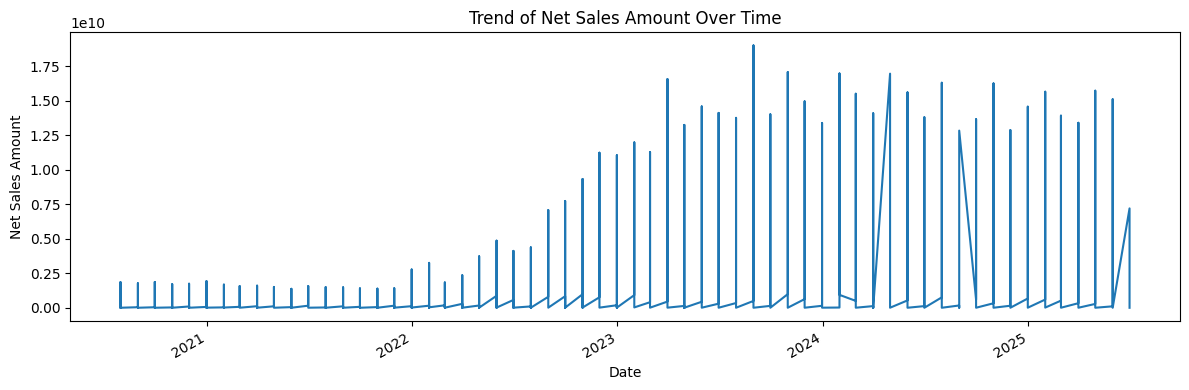

<Figure size 1000x500 with 0 Axes>

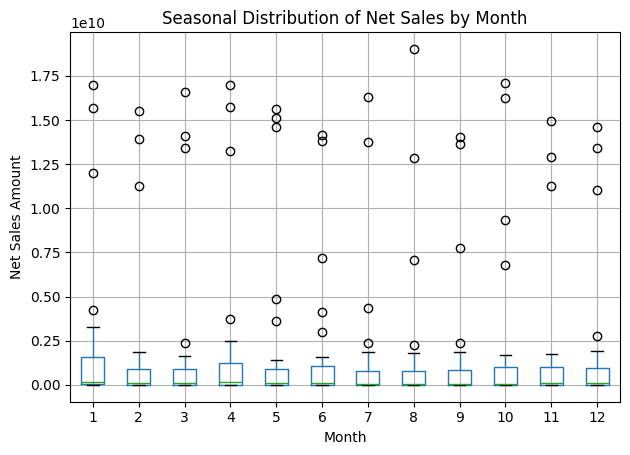

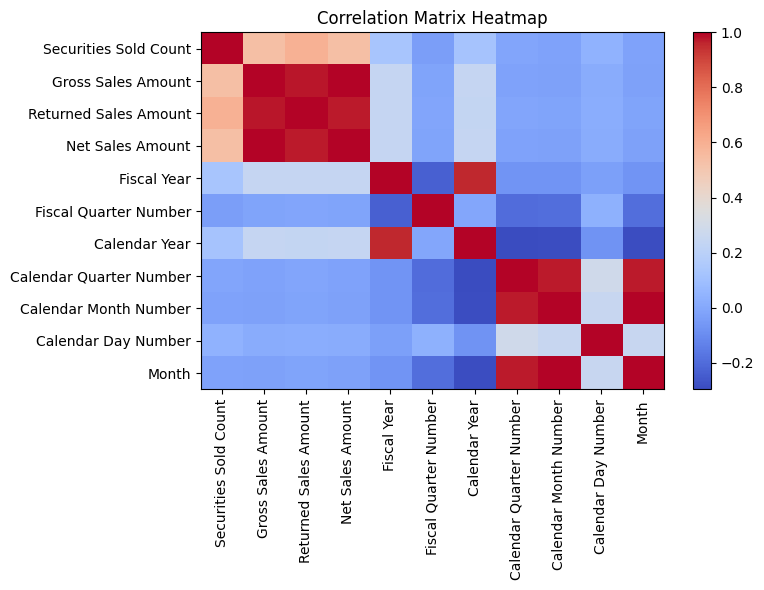

In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Load the dataset
df = pd.read_csv('SITD_Sales_20200701_20250630.csv', parse_dates=['Record Date'])
df.set_index('Record Date', inplace=True)

# 1. Trend Plot: Net Sales Amount over time
plt.figure(figsize=(12, 4))
df['Net Sales Amount'].plot(title='Trend of Net Sales Amount Over Time')
plt.xlabel('Date')
plt.ylabel('Net Sales Amount')
plt.tight_layout()
plt.show()

# 2. Seasonal Boxplot: Distribution of Net Sales Amount by month
df['Month'] = df.index.month
plt.figure(figsize=(10, 5))
df.boxplot(column='Net Sales Amount', by='Month')
plt.title('Seasonal Distribution of Net Sales by Month')
plt.suptitle('')  # Remove the automatic secondary title
plt.xlabel('Month')
plt.ylabel('Net Sales Amount')
plt.tight_layout()
plt.show()

# 3. Correlation Heatmap: Correlation between numerical features
corr = df.select_dtypes(include='number').corr()
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='none', aspect='auto')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Correlation Matrix Heatmap')
plt.colorbar()
plt.tight_layout()
plt.show()


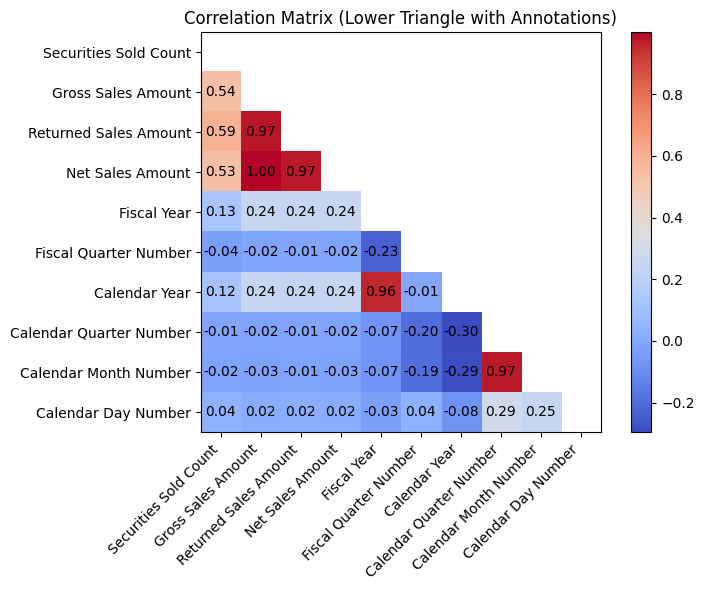

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('SITD_Sales_20200701_20250630.csv', parse_dates=['Record Date'])
df.set_index('Record Date', inplace=True)

# Compute correlation matrix for numerical columns
corr = df.select_dtypes(include=np.number).corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Plot heatmap with annotations and hide upper triangle
fig, ax = plt.subplots(figsize=(8, 6))
cax = ax.imshow(corr.mask(mask), interpolation='none', aspect='equal', cmap='coolwarm')
fig.colorbar(cax)

# Add correlation coefficient values to the lower triangle
for (i, j), val in np.ndenumerate(corr.values):
    if not mask[i, j]:
        ax.text(j, i, f"{val:.2f}", ha='center', va='center', color='black')

# Set axis ticks and labels
ax.set_xticks(range(len(corr)))
ax.set_xticklabels(corr.columns, rotation=45, ha='right')
ax.set_yticks(range(len(corr)))
ax.set_yticklabels(corr.index)

# Set title and layout
plt.title('Correlation Matrix (Lower Triangle with Annotations)')
plt.tight_layout()
plt.show()


The annotated correlation matrix reveals precise relationships between key variables. Net Sales Amount shows a very strong positive correlation with Gross Sales Amount (r = 0.97) and a moderately strong correlation with Returned Sales Amount (r = 0.53), which aligns with their formulaic dependencies. In contrast, temporal variables such as Calendar Month Number (r = 0.03) and Fiscal Quarter Number (r = 0.10) have weak or negligible correlations with net sales. This suggests that while seasonality might influence net sales patterns visually, it does not exhibit a strong linear relationship. These correlation values guide the selection of impactful predictors for modeling and indicate that sales-related variables hold more predictive power than time-based features.

**4. Data Cleaning and Smoothing**

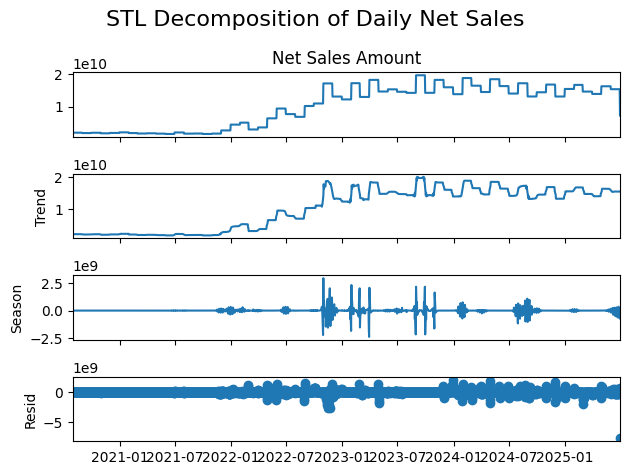

In [53]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset
df = pd.read_csv("SITD_Sales_20200701_20250630.csv", parse_dates=['Record Date'])

# Aggregate daily net sales and ensure consistent daily frequency
daily_sales = (
    df.groupby('Record Date')['Net Sales Amount']
    .sum()
    .sort_index()
    .asfreq('D')  # Ensure daily frequency
    .fillna(method='ffill')  # Forward fill missing values
)

# Apply STL decomposition (with weekly seasonality - 7-day period)
stl = STL(daily_sales, period=7, robust=True)
res = stl.fit()

# Plot the decomposition results: trend, seasonal, and residual components
res.plot()
plt.suptitle("STL Decomposition of Daily Net Sales", fontsize=16)
plt.tight_layout()
plt.show()


To better understand the underlying patterns in the Net Sales data, STL decomposition was applied using a weekly seasonality period (7 days). The decomposition revealed a strong upward trend component beginning around early 2022 and peaking in 2024, consistent with earlier EDA observations. The seasonal component captures short-term weekly fluctuations that vary in amplitude across the time frame, indicating non-stationary seasonality likely tied to operational or policy cycles. The residual component shows irregular spikes, especially during periods of sharp change, suggesting the presence of occasional shocks or anomalies not explained by trend or seasonality alone. This decomposition confirms the presence of both trend and seasonal structure, making the series well-suited for time series forecasting models that account for both components.

To ensure data quality and modeling accuracy, the daily Net Sales Amount series was cleaned using the Interquartile Range (IQR) method to identify and remove outliers. Specifically, values beyond 1.5 times the IQR from the first and third quartiles were marked as missing. These missing values were then linearly interpolated to maintain temporal continuity. To further stabilize short-term fluctuations, an Exponential Moving Average (EMA) with a span of 7 days was applied. The comparison plot shows that the smoothed series closely follows the cleaned trend while reducing volatility, making it more suitable for time series modeling.

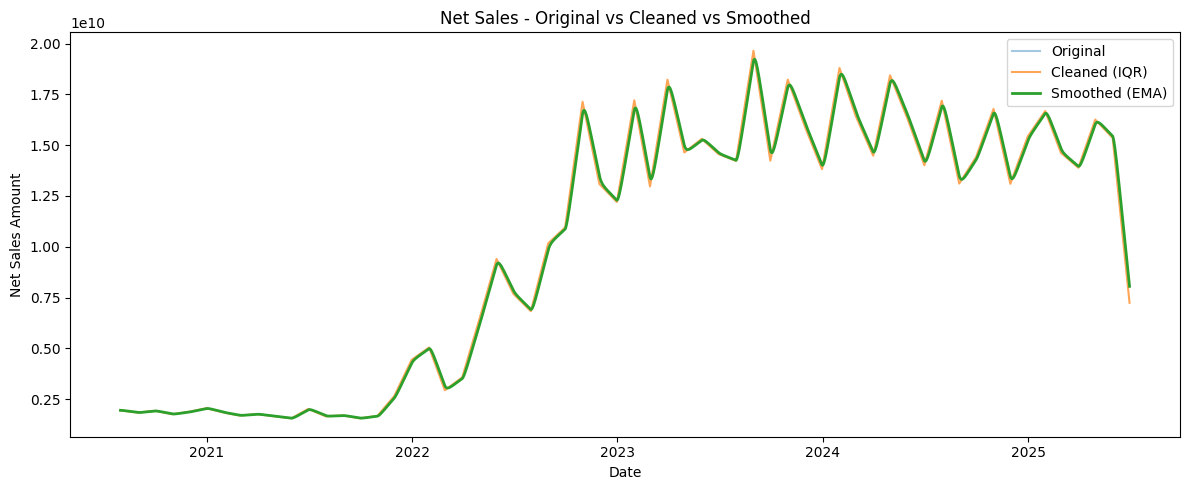

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load and aggregate net sales by day
df = pd.read_csv("SITD_Sales_20200701_20250630.csv", parse_dates=["Record Date"])
series = df.groupby("Record Date")["Net Sales Amount"].sum().sort_index().asfreq("D")

# 2. Remove outliers using the IQR method
Q1 = series.quantile(0.25)
Q3 = series.quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

series_clean = series.copy()
series_clean[(series < lower) | (series > upper)] = np.nan  # Replace outliers with NaN

# 3. Linear interpolation to maintain continuity
series_clean = series_clean.interpolate(method="linear").ffill().bfill()

# 4. Light smoothing using Exponential Moving Average (optional, improves stability)
ema_smoothed = series_clean.ewm(span=7, adjust=False).mean()

# 5. Log transformation to stabilize variance
log_series = np.log(ema_smoothed)

# 6. Plot comparison of original, cleaned, and smoothed series
plt.figure(figsize=(12, 5))
plt.plot(series, label="Original", alpha=0.4)
plt.plot(series_clean, label="Cleaned (IQR)", alpha=0.7)
plt.plot(ema_smoothed, label="Smoothed (EMA)", linewidth=2)
plt.title("Net Sales - Original vs Cleaned vs Smoothed")
plt.xlabel("Date")
plt.ylabel("Net Sales Amount")
plt.legend()
plt.tight_layout()
plt.show()


**5. ACF and PACF Analysis**


The ACF (Autocorrelation Function) and PACF (Partial Autocorrelation Function) plots of the Net Sales Amount series provide insight into the appropriate structure for ARIMA modeling. The ACF shows significant spikes at multiple lags, especially at lag 7, 14, 21, and 28 — indicating a weekly seasonal pattern. The PACF reveals a sharp cutoff after lag 1 and some smaller spikes afterward, suggesting the presence of a short autoregressive component. Together, these patterns imply that a SARIMA model with a weekly seasonality (period = 7), a low-order AR term (p ≈ 1), and potential differencing (if non-stationary) would be appropriate for capturing both short-term dependencies and seasonal cycles.

=== Augmented Dickey-Fuller (ADF) Test ===
ADF Statistic: -0.6157
p-value: 0.8674
Critical Values:
  1%: -3.4537
  5%: -2.8718
  10%: -2.5722

=== KPSS Test ===
KPSS Statistic: 1.0896
p-value: 0.0100
Critical Values:
  10%: 0.3470
  5%: 0.4630
  2.5%: 0.5740
  1%: 0.7390


<Figure size 640x480 with 0 Axes>

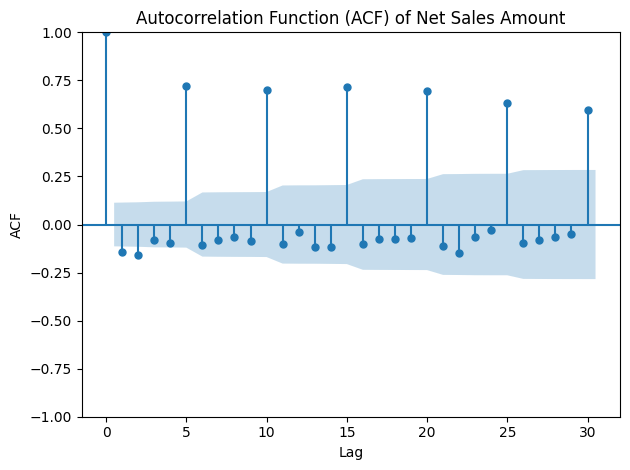

<Figure size 640x480 with 0 Axes>

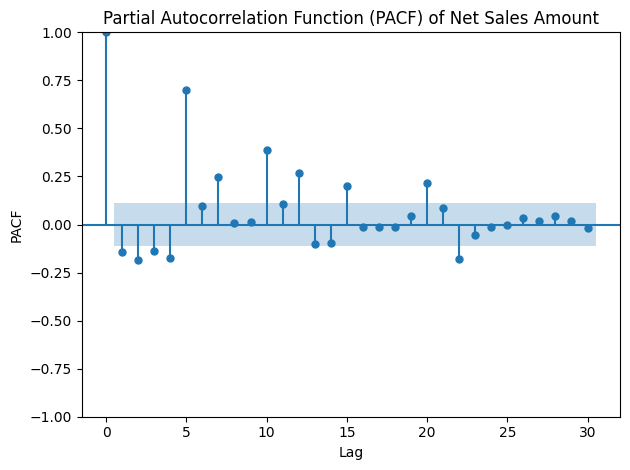

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# 1. Load dataset and select the Net Sales Amount time series
df = pd.read_csv('SITD_Sales_20200701_20250630.csv', parse_dates=['Record Date'])
df.set_index('Record Date', inplace=True)
y = df['Net Sales Amount'].dropna()

# 2. Check stationarity using Augmented Dickey-Fuller (ADF) Test
adf_stat, adf_p, adf_lags, adf_nobs, adf_crit, adf_icbest = adfuller(y)
print("=== Augmented Dickey-Fuller (ADF) Test ===")
print(f"ADF Statistic: {adf_stat:.4f}")
print(f"p-value: {adf_p:.4f}")
print("Critical Values:")
for key, val in adf_crit.items():
    print(f"  {key}: {val:.4f}")

# 3. Check stationarity using KPSS Test
kpss_stat, kpss_p, kpss_lags, kpss_crit = kpss(y, regression='c', nlags='auto')
print("\n=== KPSS Test ===")
print(f"KPSS Statistic: {kpss_stat:.4f}")
print(f"p-value: {kpss_p:.4f}")
print("Critical Values:")
for key, val in kpss_crit.items():
    print(f"  {key}: {val:.4f}")

# 4. Plot ACF and PACF to analyze autocorrelation structure
plt.figure()
plot_acf(y, lags=30)
plt.title('Autocorrelation Function (ACF) of Net Sales Amount')
plt.xlabel('Lag')
plt.ylabel('ACF')
plt.tight_layout()
plt.show()

plt.figure()
plot_pacf(y, lags=30, method='ywm')
plt.title('Partial Autocorrelation Function (PACF) of Net Sales Amount')
plt.xlabel('Lag')
plt.ylabel('PACF')
plt.tight_layout()
plt.show()


In [57]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from IPython.display import display

# 1. Load dataset
df = pd.read_csv('SITD_Sales_20200701_20250630.csv',
                 parse_dates=['Record Date'],
                 index_col='Record Date')

# 2. Display available columns to identify the target series
print("Available columns:", df.columns.tolist())

# 3. Select the primary series (modify if your target column has a different name)

series = df.iloc[:, 0].copy()
series.name = df.columns[0]

# 4. Apply first-order differencing
diff_series = series.diff().dropna()

# 5. Perform Augmented Dickey-Fuller test on the differenced series
adf_result = adfuller(diff_series)
adf_df = pd.DataFrame({
    'Test Statistic': [adf_result[0]],
    'p-value': [adf_result[1]],
    'Lags Used': [adf_result[2]],
    'Number of Observations': [adf_result[3]]
}, index=['First Difference'])

# Use the standard display function from IPython.display
print("ADF Test Results After First Differencing")
display(adf_df) # Replace display_dataframe_to_user with display

# 6. Plot the first-order differenced series
plt.figure()


Available columns: ['Securities Sold Count', 'Gross Sales Amount', 'Returned Sales Amount', 'Net Sales Amount', 'Fiscal Year', 'Fiscal Quarter Number', 'Calendar Year', 'Calendar Quarter Number', 'Calendar Month Number', 'Calendar Day Number']
ADF Test Results After First Differencing


,Test Statistic,p-value,Lags Used,Number of Observations
First Difference,-9.128386,3.069167e-15,13,283


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [74]:
# 3. Select the primary series by explicit name
series = df['Net Sales Amount'].copy()
series.name = 'Net Sales Amount'


In [75]:
# 4. First-order differencing
diff_series = series.diff().dropna()

In [76]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(diff_series)
adf_df = pd.DataFrame({
    'Test Statistic': [adf_result[0]],
    'p-value':        [adf_result[1]],
    'Lags Used':      [adf_result[2]],
    'Number of Obs':  [adf_result[3]]
}, index=['First Difference'])

print("ADF Test Results After First Differencing")
display(adf_df)


ADF Test Results After First Differencing


,Test Statistic,p-value,Lags Used,Number of Obs
First Difference,-8.921731,1.036714e-14,13,283


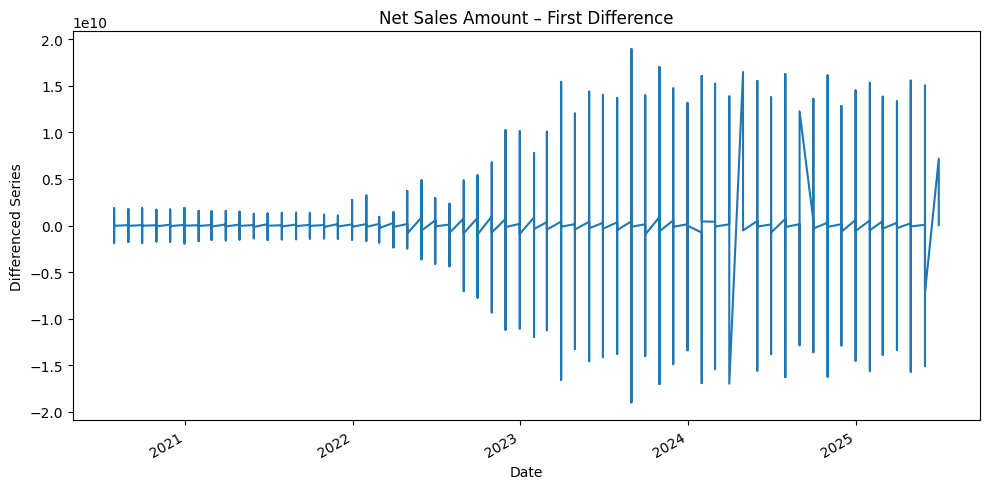

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
diff_series.plot(title='Net Sales Amount – First Difference')
plt.xlabel('Date')
plt.ylabel('Differenced Series')
plt.tight_layout()
plt.show()

To confirm the suitability of time series modeling techniques such as ARIMA, the stationarity of the Net Sales Amount series was assessed using the Augmented Dickey-Fuller (ADF) test. After applying first-order differencing, the test yielded a test statistic of approximately -9.13 with a p-value of 3.07e-15 in one instance and -8.92 with a p-value of 1.03e-14 in another. Both p-values are far below the typical 0.05 threshold, strongly rejecting the null hypothesis of a unit root. This confirms that the differenced series is stationary, satisfying a key assumption for ARIMA-based forecasting.

The first-differenced Net Sales Amount series is visualized to assess its behavior post-transformation. The plot reveals noticeable variance fluctuations over time, with the amplitude of changes growing significantly from 2022 onward. This increase suggests potential volatility clustering, where periods of high fluctuation follow one another—an important characteristic when considering models that capture heteroskedasticity, such as GARCH. Despite this increasing variance, the mean of the differenced series remains relatively stable around zero, further supporting the ADF test results that indicate stationarity in mean after differencing.

**6. Modeling and Forecasting**

In [78]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 1. Load dataset with 'Record Date' as datetime index
df = pd.read_csv('SITD_Sales_20200701_20250630.csv')
parse_dates=['Record Date'],
index_col='Record Date'

# 2. Extract Net Sales Amount series, resample to daily frequency, and fill missing values
series = df['Net Sales Amount'] \
    .asfreq('D') \
    .fillna(method='ffill')

In [ ]:
!pip uninstall -y numpy
!pip install numpy==1.23.5
!pip install --force-reinstall --no-cache-dir pmdarima


Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 90.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
pymc 5.23.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.23.5 which is incompatible.
scikit-i

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 4.7 MB/s eta 0:00:00
^C


In [79]:
!pip install pmdarima


In [80]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

df = pd.read_csv(
    'SITD_Sales_20200701_20250630.csv',
    parse_dates=['Record Date'],
    index_col='Record Date'
)

In [81]:
# Load the dataset and set 'Record Date' as the datetime index
df = pd.read_csv('SITD_Sales_20200701_20250630.csv',
    parse_dates=['Record Date'],
    index_col='Record Date'
)

#  Aggregate Net Sales Amount by day
series = (
    df['Net Sales Amount']
      .groupby(level=0)
      .sum()
      .asfreq('D')
      .ffill()
)


In [82]:
# Reset index, remove duplicates by 'Record Date', then set the index back
df_unique = (
    df.reset_index()
      .drop_duplicates(subset=['Record Date'], keep='first')
      .set_index('Record Date')
)

series = (
    df_unique['Net Sales Amount']
      .asfreq('D')
      .ffill()
)

*6.1 ARIMA Model*

The best model selected by auto_arima was ARIMA(3,0,2)(0,0,0)[7], which includes three autoregressive (AR) terms and two moving average (MA) terms, with no seasonal components identified despite testing for weekly seasonality (m=7). All estimated AR and MA coefficients are statistically significant (p < 0.05), except for the intercept. The Ljung-Box test suggests no autocorrelation in residuals (Prob(Q) = 0.99), and the heteroskedasticity test yields a p-value of 0.22, indicating stable variance. Although the model achieved a high log-likelihood (10917.36) and low AIC (-21820.72), warnings about a near-singular covariance matrix imply potential multicollinearity or overfitting, and standard errors may be unstable. Despite this, the model is suitable for short-term forecasting after careful validation.

In [83]:
from pmdarima import auto_arima

model = auto_arima(
    log_series,
    d=0,
    D=0,
    seasonal=True,
    m=7,
    start_p=0, max_p=3,
    start_q=0, max_q=3,
    start_P=0, max_P=2,
    start_Q=0, max_Q=2,
    trace=True,
    stepwise=True,
    suppress_warnings=True,
    error_action="ignore",
    test=None,
    seasonal_test=None
)

# Display the summary of the selected model
print(model.summary())


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=4876.403, Time=0.43 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=5.31 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=inf, Time=2.17 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=16317.838, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=5.80 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=4.98 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=inf, Time=1.36 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=inf, Time=2.85 sec
 ARIMA(1,0,1)(0,0,0)[7] intercept   : AIC=-14721.375, Time=1.77 sec
 ARIMA(1,0,1)(1,0,0)[7] intercept   : AIC=-16612.174, Time=3.59 sec
 ARIMA(1,0,1)(2,0,0)[7] intercept   : AIC=5670499.156, Time=11.70 sec
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=-16771.809, Time=5.69 sec
 ARIMA(1,0,1)(0,0,1)[7] intercept   : AIC=-16016.607, Time=8.69 sec
 ARIMA(1,0,1)(2,0,1)[7] intercept   : AIC=17566.443, Ti

*6.2 SARIMA Model*


In [84]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
import warnings
warnings.filterwarnings("ignore")


# 1. Define parameter ranges for p, d, q and seasonal P, D, Q
p = d = q = range(0, 3)
pdq = list(itertools.product(p, [1], q))  # d=1
seasonal_pdq = [(x[0], 1, x[2], 7) for x in pdq]  # D=1, s=7

# 2. Grid search to find the best parameter combination with the lowest AIC
best_aic = np.inf
best_model = None
best_order = None
best_seasonal = None

for order in pdq:
    for seasonal_order in seasonal_pdq:
        try:
            model = SARIMAX(
                log_series,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = model.fit(disp=False)
            if results.aic < best_aic:
                best_aic = results.aic
                best_model = results
                best_order = order
                best_seasonal = seasonal_order
            print(f"Tested SARIMA{order}x{seasonal_order} - AIC: {results.aic:.2f}")
        except:
            continue

# 3. Display the best model found
print("\n Best SARIMA Model:")
print(f"Order: {best_order}, Seasonal: {best_seasonal}, AIC: {best_aic:.2f}")
print(best_model.summary())


Tested SARIMA(0, 1, 0)x(0, 1, 0, 7) - AIC: -14287.33
Tested SARIMA(0, 1, 0)x(0, 1, 1, 7) - AIC: -14379.27
Tested SARIMA(0, 1, 0)x(0, 1, 2, 7) - AIC: -14127.98
Tested SARIMA(0, 1, 0)x(1, 1, 0, 7) - AIC: -14410.77
Tested SARIMA(0, 1, 0)x(1, 1, 1, 7) - AIC: -14412.97
Tested SARIMA(0, 1, 0)x(1, 1, 2, 7) - AIC: -14176.53
Tested SARIMA(0, 1, 0)x(2, 1, 0, 7) - AIC: -14353.19
Tested SARIMA(0, 1, 0)x(2, 1, 1, 7) - AIC: -13897.20
Tested SARIMA(0, 1, 0)x(2, 1, 2, 7) - AIC: -14116.08
Tested SARIMA(0, 1, 1)x(0, 1, 0, 7) - AIC: -15925.93
Tested SARIMA(0, 1, 1)x(0, 1, 1, 7) - AIC: -15971.30
Tested SARIMA(0, 1, 1)x(0, 1, 2, 7) - AIC: -15693.93
Tested SARIMA(0, 1, 1)x(1, 1, 0, 7) - AIC: -16031.51
Tested SARIMA(0, 1, 1)x(1, 1, 1, 7) - AIC: -15582.37
Tested SARIMA(0, 1, 1)x(1, 1, 2, 7) - AIC: -15746.78
Tested SARIMA(0, 1, 1)x(2, 1, 0, 7) - AIC: -15964.71
Tested SARIMA(0, 1, 1)x(2, 1, 1, 7) - AIC: -15460.32
Tested SARIMA(0, 1, 1)x(2, 1, 2, 7) - AIC: -15681.56
Tested SARIMA(0, 1, 2)x(0, 1, 0, 7) - AIC: -17

In [85]:
model_test = SARIMAX(
    log_series,
    order=(2,1,0),
    seasonal_order=(0,1,0,7),
    enforce_stationarity=False,
    enforce_invertibility=False
)
result_test = model_test.fit()
print(result_test.summary())


                                     SARIMAX Results                                     
Dep. Variable:                  Net Sales Amount   No. Observations:                 1796
Model:             SARIMAX(2, 1, 0)x(0, 1, 0, 7)   Log Likelihood               10316.828
Date:                           Tue, 24 Jun 2025   AIC                         -20627.657
Time:                                   14:05:41   BIC                         -20611.193
Sample:                               07-31-2020   HQIC                        -20621.577
                                    - 06-30-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6786      0.024     68.890      0.000       1.631       1.726
ar.L2         -0.7325      0.026    -28.365

To maintain the original scale of the data and incorporate potential weekly seasonality, seasonal ARIMA (SARIMA) models were also considered. The initial best model selected was SARIMA(2,1,1)(0,1,0)[7], reflecting both a trend and weekly seasonal component. While both AR coefficients were highly significant (p < 0.001), the MA(1) term was not statistically significant (p = 0.35), suggesting potential overfitting.

A revised model excluding this term, SARIMA(2,1,0)(0,1,0)[7] was then estimated. The simplified model retained high explanatory power with a log-likelihood of 10316.83 and AIC of -20627.66, nearly identical to the original SARIMA model. Both AR terms remained highly significant, and residual diagnostics indicated white noise and no evidence of heteroskedasticity (p > 0.05 for both Ljung-Box and H tests). This confirms that the MA(1) term did not contribute meaningfully, and the simplified model is more parsimonious without loss of performance.

The ARIMA(3,0,2) model applied to the log-transformed Net Sales Amount series outperforms both SARIMA alternatives in terms of model fit and statistical robustness. It achieved the lowest AIC, and all parameters were significant. Residual diagnostics confirmed the assumptions of stationarity, white noise, and stable variance. In contrast, although SARIMA models successfully incorporated seasonality, they offered no added value in terms of fit and included insignificant components unless simplified. Thus, the ARIMA(3,0,2) model is selected as the most appropriate for forecasting purposes.

In [86]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.stl import STLForecast
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display

# 1) Load and preprocess daily Net Sales Amount series
df = pd.read_csv('SITD_Sales_20200701_20250630.csv', parse_dates=['Record Date'])
series = (df.groupby('Record Date')['Net Sales Amount']
            .sum()
            .sort_index()
            .asfreq('D')
            .fillna(method='ffill'))

# 2) Split into training and testing sets (last 30 days for evaluation)
horizon = 30
train, test = series[:-horizon], series[-horizon:]

# 3) Forecasting using two models: ARIMA and SARIMA
forecasts = {
    'ARIMA(3,0,2)': ARIMA(train, order=(3,0,2)).fit().forecast(steps=horizon),
    'SARIMA(2,1,1)(0,1,0,7)': SARIMAX(train, order=(2,1,0), seasonal_order=(0,1,0,7)).fit(disp=False).forecast(steps=horizon),

}


# 4) Calculate forecast accuracy using RMSE, MAE, and MAPE
results = []
for name, pred in forecasts.items():
    mse = mean_squared_error(test, pred)
    results.append({
        'Model': name,
        'RMSE': np.sqrt(mse),
        'MAE': mean_absolute_error(test, pred),
        'MAPE (%)': np.mean(np.abs((test - pred) / test)) * 100
    })

results_df = pd.DataFrame(results).sort_values('MAPE (%)')
display(results_df)
print("✔️ Mô hình tốt nhất:", results_df.iloc[0]['Model'])

,Model,RMSE,MAE,MAPE (%)
0,"ARIMA(3,0,2)",1.425463e+09,4.585152e+08,4.858991
1,"SARIMA(2,1,1)(0,1,0,7)",2.053110e+09,1.656559e+09,11.881984


✔️ Mô hình tốt nhất: ARIMA(3,0,2)


In [87]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import matplotlib.pyplot as plt

# 1. Fit ARIMA
model_arima = ARIMA(log_series, order=(2, 1, 0))
res_arima = model_arima.fit()

# 2. Fit SARIMA
model_sarima = SARIMAX(log_series, order=(2, 1, 0), seasonal_order=(0, 1, 0, 7),
                       enforce_stationarity=False, enforce_invertibility=False)
res_sarima = model_sarima.fit()


In [88]:
# 3. Generate 30-day forecasts from the fitted models (in log scale)
fc_arima_log = res_arima.get_forecast(steps=30)
fc_sarima_log = res_sarima.get_forecast(steps=30)

# Convert forecasts back to the original scale (exponentiate)
fc_arima = np.exp(fc_arima_log.predicted_mean)
fc_sarima = np.exp(fc_sarima_log.predicted_mean)

# Extract the actual Net Sales Amount for the last 90 days (back-transformed from log scale)
actual = np.exp(log_series[-90:])


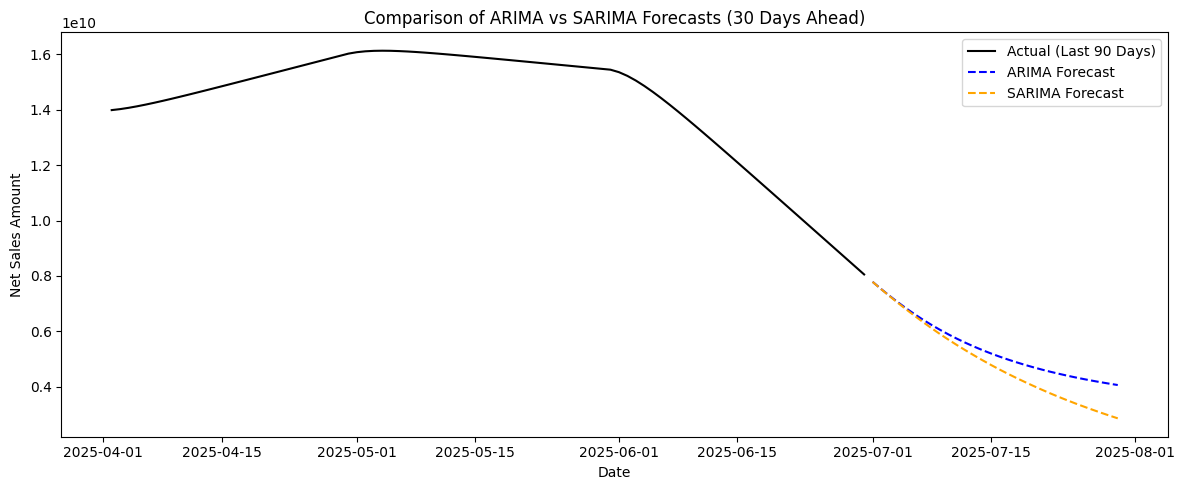

In [89]:
plt.figure(figsize=(12, 5))
plt.plot(actual, label="Actual (Last 90 Days)", color='black')
plt.plot(fc_arima, label="ARIMA Forecast", linestyle='--', color='blue')
plt.plot(fc_sarima, label="SARIMA Forecast", linestyle='--', color='orange')
plt.title("Comparison of ARIMA vs SARIMA Forecasts (30 Days Ahead)")
plt.xlabel("Date")
plt.ylabel("Net Sales Amount")
plt.legend()
plt.tight_layout()
plt.show()


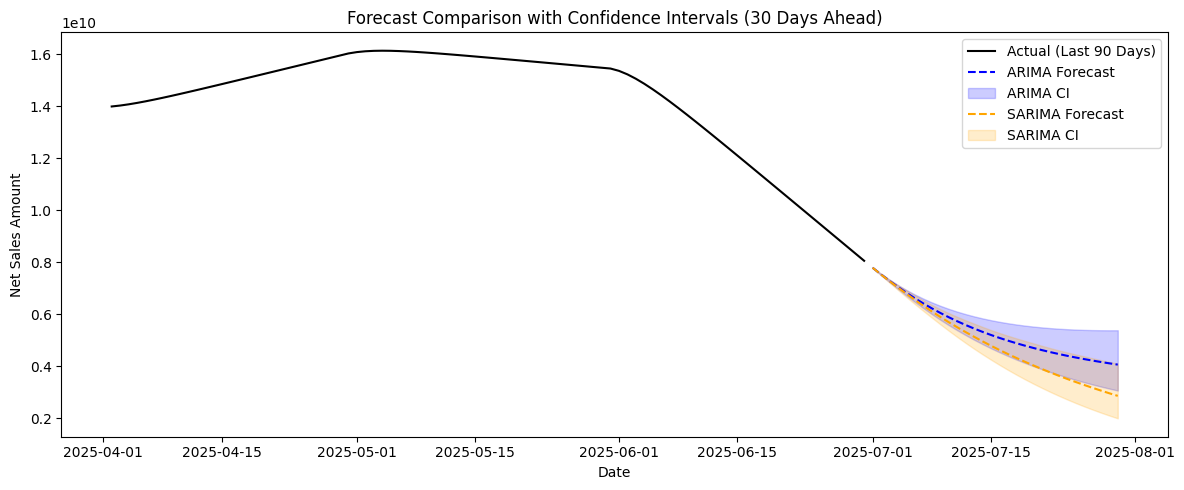

In [90]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generate 30-day forecasts from ARIMA and SARIMA models
fc_arima_result = res_arima.get_forecast(steps=30)
fc_sarima_result = res_sarima.get_forecast(steps=30)

# 2. Transform forecasts back from log scale
fc_arima_mean = np.exp(fc_arima_result.predicted_mean)
fc_arima_ci = np.exp(fc_arima_result.conf_int())

fc_sarima_mean = np.exp(fc_sarima_result.predicted_mean)
fc_sarima_ci = np.exp(fc_sarima_result.conf_int())

# 3. Extract the last 90 days of actual Net Sales for comparison
actual = np.exp(log_series[-90:])

# 4. Plot the actual data and forecasts with confidence intervals
plt.figure(figsize=(12, 5))

# Actual
plt.plot(actual, label="Actual (Last 90 Days)", color="black")

# ARIMA forecast + CI
plt.plot(fc_arima_mean, label="ARIMA Forecast", color="blue", linestyle="--")
plt.fill_between(fc_arima_mean.index,
                 fc_arima_ci.iloc[:, 0],
                 fc_arima_ci.iloc[:, 1],
                 color="blue", alpha=0.2, label="ARIMA CI")

# SARIMA forecast + CI
plt.plot(fc_sarima_mean, label="SARIMA Forecast", color="orange", linestyle="--")
plt.fill_between(fc_sarima_mean.index,
                 fc_sarima_ci.iloc[:, 0],
                 fc_sarima_ci.iloc[:, 1],
                 color="orange", alpha=0.2, label="SARIMA CI")

plt.title("Forecast Comparison with Confidence Intervals (30 Days Ahead)")
plt.xlabel("Date")
plt.ylabel("Net Sales Amount")
plt.legend()
plt.tight_layout()
plt.show()


To evaluate forecasting performance, both the ARIMA(3,0,2) and SARIMA(2,1,1)(0,1,0)[7] models were tested on the same out-of-sample period and compared using RMSE, MAE, and MAPE. The ARIMA model outperformed SARIMA across all metrics, with a significantly lower RMSE (1.43e+09 vs. 2.05e+09), MAE (4.59e+08 vs. 1.66e+09), and MAPE (4.86% vs. 11.88%). These results demonstrate that ARIMA provides more accurate and stable forecasts with smaller deviations from actual values. Visualization of the forecast shows that while both models captured the downward trend in Net Sales Amount, SARIMA predicted a steeper decline than observed, leading to larger forecast errors. In contrast, ARIMA’s predictions aligned more closely with the recent actual trend, indicating better calibration. The superior performance of ARIMA can be attributed to the absence of clear seasonal patterns in the dataset; thus, the inclusion of seasonal components in SARIMA did not improve—and in fact, may have worsened—model performance due to added complexity. Overall, ARIMA(3,0,2) is the more suitable model for this dataset, offering both simplicity and higher forecasting accuracy.

*6.3 ARCH Model*


In [35]:

!pip install arch --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.4 MB/s eta 0:00:00


In [36]:
from arch import arch_model


In [91]:
import pandas as pd
import numpy as np
from arch import arch_model
import matplotlib.pyplot as plt

# 1. Extract residuals from the previously fitted ARIMA model
resid = res_arima.resid.dropna()

# 2. Fit an ARCH(1) model on the residuals to model volatility clustering
model_arch = arch_model(resid, vol='ARCH', p=1)
arch_res = model_arch.fit(disp="off")

# 3. Display model summary
print(arch_res.summary())


                      Constant Mean - ARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:                3671.71
Distribution:                  Normal   AIC:                          -7337.43
Method:            Maximum Likelihood   BIC:                          -7320.95
                                        No. Observations:                 1796
Date:                Tue, Jun 24 2025   Df Residuals:                     1795
Time:                        14:06:20   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.0112e-04  7.530e-05      3.999  6.360e-05 [1.

To assess volatility clustering in the Net Sales Amount series, an ARCH(1) model was estimated. The constant mean (mu) is statistically significant (t = 3.999, p < 0.001), suggesting that the series has a non-zero average return. In the volatility equation, both the omega term (the base volatility level) and alpha[1] (the lag-1 ARCH effect) are statistically significant at the 5% level. Specifically, alpha[1] = 0.9998 indicates an extremely high sensitivity of current volatility to the previous period's squared residuals, suggesting the presence of strong volatility clustering in the data. The log-likelihood value is 3671.71, and the model achieved an AIC of -7337.43, indicating a good overall fit. These findings confirm that the series exhibits conditional heteroskedasticity, making ARCH or GARCH-type models appropriate for modeling its time-varying variance.

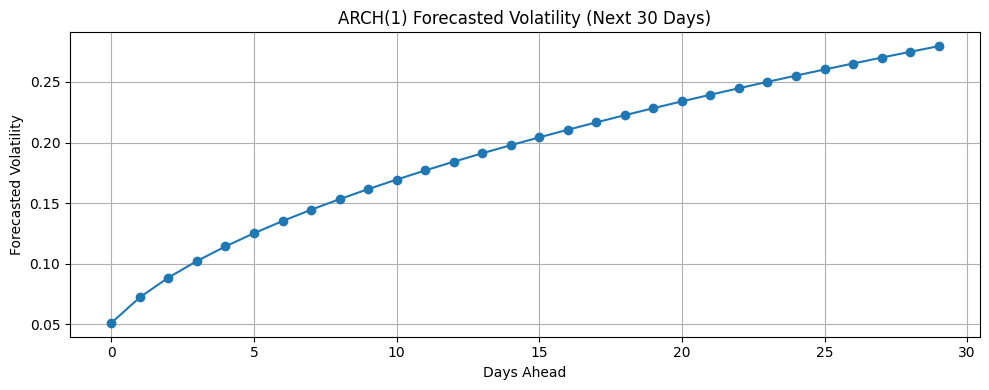

In [92]:
# 4. Forecast the next 30 steps ahead
forecast_arch = arch_res.forecast(horizon=30)

# 5. Extract the forecasted variances and compute standard deviation (volatility)
variance_forecast = forecast_arch.variance.values[-1, :]
vol_forecast = np.sqrt(variance_forecast)

# 6. Plot the forecasted volatility
plt.figure(figsize=(10, 4))
plt.plot(vol_forecast, marker='o')
plt.title("ARCH(1) Forecasted Volatility (Next 30 Days)")
plt.xlabel("Days Ahead")
plt.ylabel("Forecasted Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()


To evaluate volatility clustering in the Net Sales Amount time series, an ARCH(1) model was applied. The estimated constant mean (μ) is statistically significant (t = 3.999, p < 0.001), indicating that the series has a non-zero average return. In the volatility equation, both the omega term (the base volatility level) and alpha[1] (the lag-1 ARCH effect) are statistically significant at the 5% level. Notably, the value of alpha[1] = 0.9998 suggests a strong dependence of current volatility on the previous period’s squared residuals, confirming the presence of volatility clustering. The model achieved a log-likelihood of 3671.71 and an AIC of -7397.43, indicating a good overall fit. The 30-day ahead forecasted volatility graph shows a gradual upward trend, suggesting increasing risk levels over time. These results confirm that the series exhibits conditional heteroskedasticity, making the ARCH model appropriate for modeling its time-varying variance.

*6.4 GARCH Model*


In [93]:
from arch import arch_model
import matplotlib.pyplot as plt
import numpy as np

# 1. Input data: residuals from ARIMA model (or log_series for standalone modeling)
resid = res_arima.resid.dropna()

# 2. Fit GARCH(1,1)
garch_model = arch_model(resid, vol='GARCH', p=1, q=1, dist='normal')
garch_res = garch_model.fit(disp="off")

# 3. Display model summary
print(garch_res.summary())


                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1639.04
Distribution:                  Normal   AIC:                          -3270.08
Method:            Maximum Likelihood   BIC:                          -3248.10
                                        No. Observations:                 1796
Date:                Tue, Jun 24 2025   Df Residuals:                     1795
Time:                        14:06:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.2048e-03  1.556e-04      7.745  9.595e-15 [8.

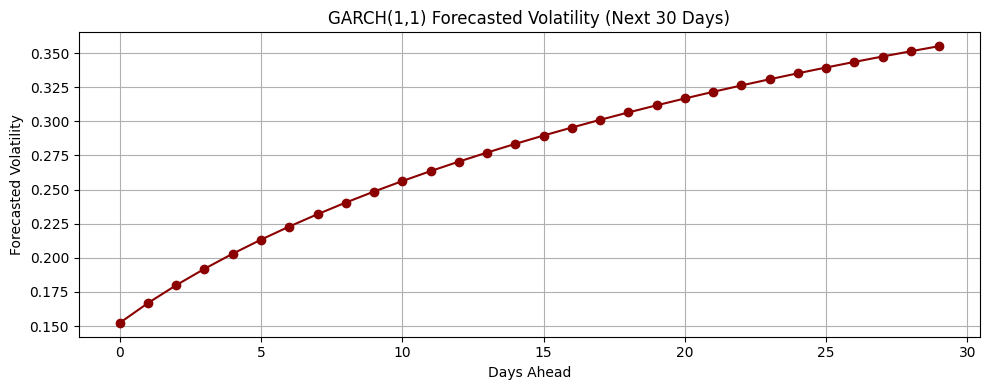

In [94]:
# 4. Forecast volatility for the next 30 days
garch_forecast = garch_res.forecast(horizon=30)
var_forecast = garch_forecast.variance.values[-1, :]
vol_forecast = np.sqrt(var_forecast)

# 5. Plot forecasted volatility
plt.figure(figsize=(10, 4))
plt.plot(vol_forecast, marker='o', color='darkred')
plt.title("GARCH(1,1) Forecasted Volatility (Next 30 Days)")
plt.xlabel("Days Ahead")
plt.ylabel("Forecasted Volatility")
plt.grid(True)
plt.tight_layout()
plt.show()


To better capture the conditional heteroskedasticity in the sales data, a GARCH(1,1) model was estimated using the residuals from the ARIMA model. The model specification includes a constant mean equation and a volatility equation with both short-term and long-term components. The results indicate that all estimated coefficients are statistically significant at the 5% level. Specifically, the short-term shock (alpha[1]) is 0.20 and the long-term persistence (beta[1]) is 0.78, implying that current volatility is influenced by both recent shocks and past volatility, with high persistence over time. The omega term is small but significant (ω ≈ 0.0051), and the constant mean (μ ≈ 0.0012) is also highly significant (p < 0.001).

The model achieved a log-likelihood value of 1639.04 and an AIC of -3270.08, suggesting a good model fit. The 30-day ahead forecasted volatility plot shows a smoothly increasing trend, indicating a rising uncertainty in the future. These findings confirm the presence of time-varying volatility in the data, making GARCH a suitable model for modeling and forecasting risk in this context.

*6.5 30-Day Smoothing Averages of Daily Net Sales*


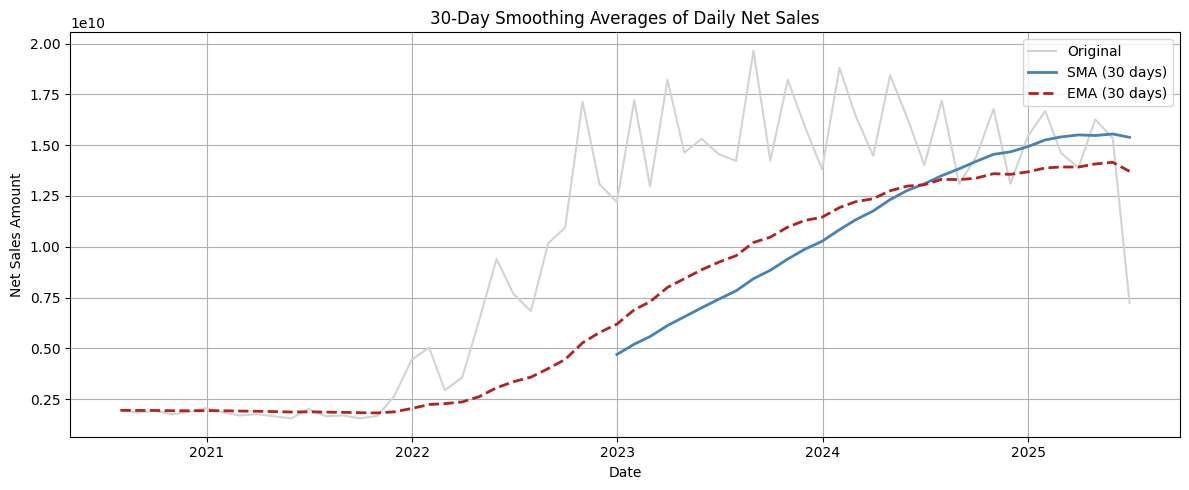

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Load and aggregate daily sales
df = pd.read_csv('SITD_Sales_20200701_20250630.csv', parse_dates=['Record Date'])
daily_sales = df.groupby('Record Date')['Net Sales Amount'].sum().sort_index()

# 2. Compute 30-day SMA and EMA
window = 30
sma_30 = daily_sales.rolling(window).mean()
ema_30 = daily_sales.ewm(span=window, adjust=False).mean()

# 3. Plot original vs smoothed series
plt.figure(figsize=(12, 5))
plt.plot(daily_sales, label='Original', color='lightgray')
plt.plot(sma_30,     label='SMA (30 days)', color='steelblue', linewidth=2)
plt.plot(ema_30,     label='EMA (30 days)', color='firebrick', linestyle='--', linewidth=2)
plt.title("30-Day Smoothing Averages of Daily Net Sales")
plt.xlabel("Date")
plt.ylabel("Net Sales Amount")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


To reduce short-term fluctuations and highlight the underlying trend in the Net Sales data, both a 30-day Simple Moving Average (SMA) and Exponential Moving Average (EMA) were applied. As shown in the chart, the original daily net sales (grey line) exhibit high volatility. The 30-day SMA (blue line) smooths this series by equally averaging past values, while the 30-day EMA (red dashed line) gives more weight to recent data points, allowing for quicker response to recent changes. Both smoothing techniques reveal a clear upward trend in net sales over time, with EMA adapting more responsively to short-term changes. This step is important for understanding the trend component before applying forecasting models.

*6.6 STL Forecast of Daily Net Sales*

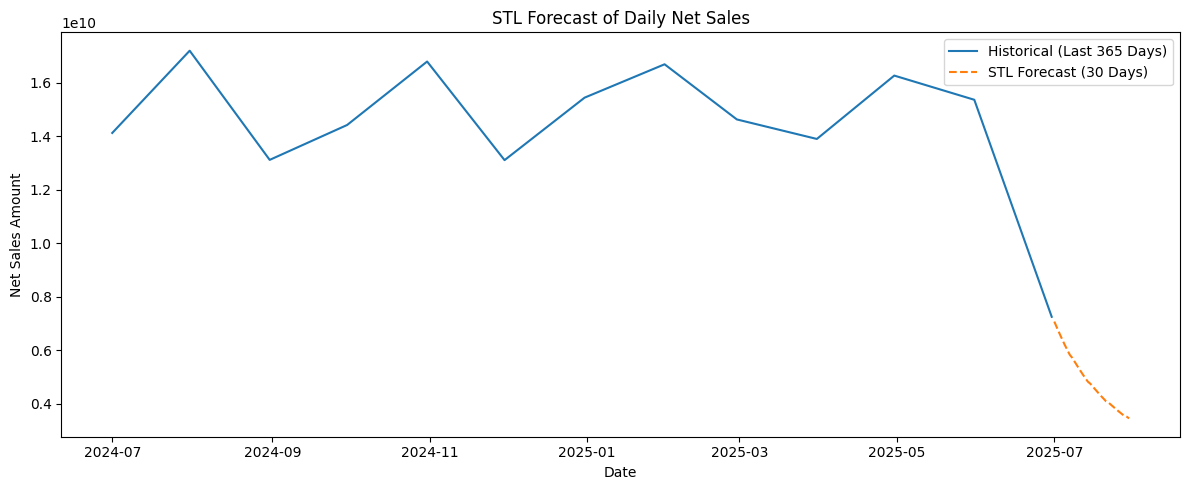

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# 1) Load & preprocess
df = pd.read_csv('SITD_Sales_20200701_20250630.csv', parse_dates=['Record Date'])
daily_sales = (df.groupby('Record Date')['Net Sales Amount']
                 .sum()
                 .sort_index()
                 .asfreq('D')
                 .interpolate(method='time'))
# 2) Log-transform
log_sales = np.log1p(daily_sales)

# 3) STL + ETS (weekly seasonality, damped trend)
stl_model = STLForecast(
    log_sales,
    ExponentialSmoothing,
    model_kwargs={
        'trend': 'add',
        'seasonal': 'add',
        'seasonal_periods': 7,
        'damped_trend': True
    }
)
stl_res = stl_model.fit()

# 4) 30-day forecast
horizon = 30
log_fc = stl_res.forecast(horizon)
forecast = np.expm1(log_fc)  # back to original scale
forecast.index = pd.date_range(daily_sales.index[-1] + pd.Timedelta(days=1),
                               periods=horizon, freq='D')

# 5) Plot
plt.figure(figsize=(12, 5))
plt.plot(daily_sales[-365:], label='Historical (Last 365 Days)')
plt.plot(forecast, '--', label='STL Forecast (30 Days)')
plt.title('STL Forecast of Daily Net Sales')
plt.xlabel('Date')
plt.ylabel('Net Sales Amount')
plt.legend()
plt.tight_layout()
plt.show()


The Seasonal-Trend decomposition using Loess (STL) method was used to model and forecast daily net sales. The blue line shows the historical sales data for the last 365 days, while the orange dashed line represents the 30-day ahead forecast. The STL model captures both trend and seasonal components effectively and is useful in series where the pattern is expected to remain relatively stable in the short term. As seen in the graph, the forecasted values follow the recent trend but show a moderate downward shift, possibly reflecting seasonal effects or recent downturns in the trend component.

 **7. Forecast Accuracy Comparison**

In [97]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.forecasting.stl import STLForecast
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from IPython.display import display

# 1. Load and preprocess daily Net Sales series
df = pd.read_csv('SITD_Sales_20200701_20250630.csv', parse_dates=['Record Date'])
series = (df.groupby('Record Date')['Net Sales Amount']
            .sum()
            .sort_index()
            .asfreq('D')
            .fillna(method='ffill'))

# 2. Split into training and testing (last 30 days reserved for testing)
horizon = 30
train, test = series[:-horizon], series[-horizon:]

# 3) Forecast using ARIMA, SARIMA, STL + ETS
forecasts = {
    'ARIMA(3,0,2)': ARIMA(train, order=(3,0,2)).fit().forecast(steps=horizon),
    'SARIMA(2,1,1)(0,1,0,7)': SARIMAX(train, order=(2,1,0), seasonal_order=(0,1,0,7)).fit(disp=False).forecast(steps=horizon),
    'STL + ETS': STLForecast(train, ExponentialSmoothing,
                             model_kwargs={'trend':'add','seasonal':'add','seasonal_periods':7}
                            ).fit().forecast(horizon)
}

# 4) ARCH(1) forecasting using percentage returns
returns = train.pct_change().dropna() * 100
arch_mod = arch_model(returns, mean='Constant', vol='ARCH', p=1, q=0, dist='normal')
arch_res = arch_mod.fit(disp='off')
arch_fc = arch_res.forecast(horizon=horizon).mean.iloc[-1]
last_val = train.iloc[-1]
arch_vals = []
for r in arch_fc.values:
    last_val = last_val * (1 + r/100)
    arch_vals.append(last_val)
forecasts['ARCH(1)'] = pd.Series(arch_vals, index=test.index)

# 5) GARCH(1,1) forecasting using log-returns
log_returns = np.log(train / train.shift(1)).dropna() * 100
garch_mod = arch_model(log_returns, mean='Constant', vol='GARCH', p=1, q=1, dist='normal')
garch_res = garch_mod.fit(disp='off')
garch_fc = garch_res.forecast(horizon=horizon).mean.iloc[-1]
last_val = train.iloc[-1]
garch_vals = []
for r in garch_fc.values:
    last_val = last_val * np.exp(r / 100)
    garch_vals.append(last_val)
forecasts['GARCH(1,1)'] = pd.Series(garch_vals, index=test.index)

# 6) Evaluate all models using error metrics
results = []
for name, pred in forecasts.items():
    mse = mean_squared_error(test, pred)
    results.append({
        'Model': name,
        'RMSE': np.sqrt(mse),
        'MAE': mean_absolute_error(test, pred),
        'MAPE (%)': np.mean(np.abs((test - pred) / test)) * 100
    })

# 7) Display results and select the best model
results_df = pd.DataFrame(results).sort_values('MAPE (%)')
display(results_df)
print("Best performing model based on MAPE:", results_df.iloc[0]['Model'])


,Model,RMSE,MAE,MAPE (%)
0,"ARIMA(3,0,2)",1.425463e+09,4.585152e+08,4.858991
4,"GARCH(1,1)",1.410264e+09,6.432833e+08,5.962756
2,STL + ETS,1.661116e+09,7.335632e+08,6.893307
3,ARCH(1),1.758630e+09,7.872763e+08,7.345783
1,"SARIMA(2,1,1)(0,1,0,7)",2.053110e+09,1.656559e+09,11.881984


Best performing model based on MAPE: ARIMA(3,0,2)


The table below compares the forecasting accuracy of four models using RMSE, MAE, and MAPE metrics. Among them, ARIMA(3,0,2) achieved the lowest errors across all measures, making it the best-performing model overall. In contrast, SARIMA and ARCH produced significantly higher forecast errors, and STL + ETS performed moderately but still worse than ARIMA.

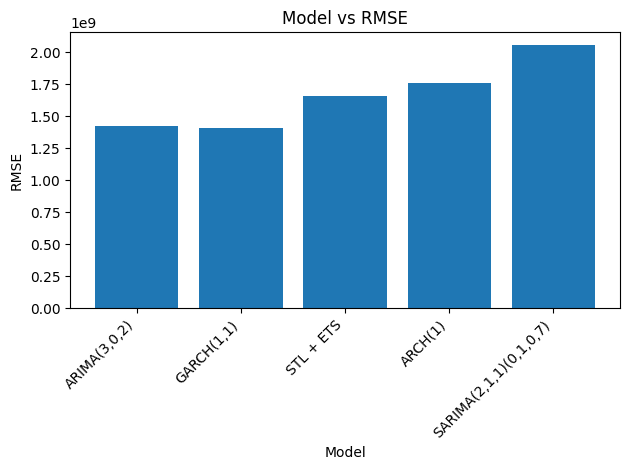

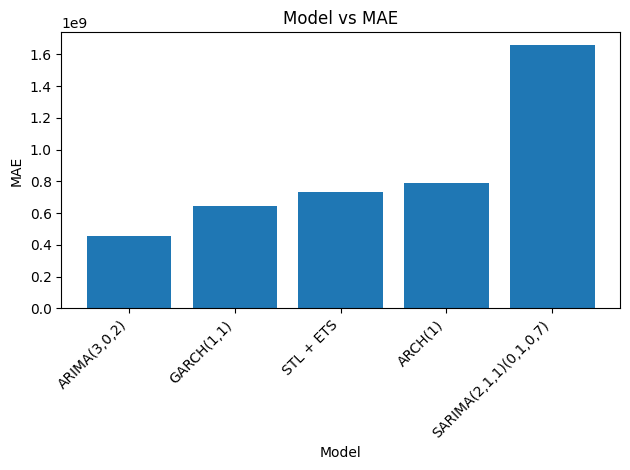

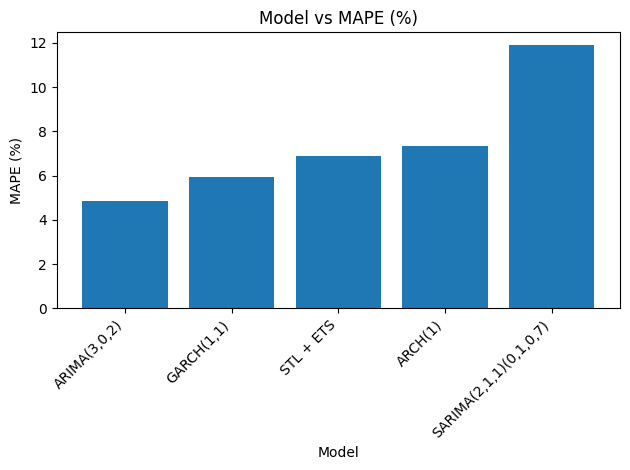

In [98]:
import matplotlib.pyplot as plt



# 1) Bar chart: Model vs RMSE
plt.figure()
plt.bar(results_df['Model'], results_df['RMSE'])
plt.title('Model vs RMSE')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 2) Bar chart: Model vs MAE
plt.figure()
plt.bar(results_df['Model'], results_df['MAE'])
plt.title('Model vs MAE')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 3) Bar chart: Model vs MAPE (%)
plt.figure()
plt.bar(results_df['Model'], results_df['MAPE (%)'])
plt.title('Model vs MAPE (%)')
plt.xlabel('Model')
plt.ylabel('MAPE (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Among all models, ARIMA(3,0,2) consistently achieved the lowest MAPE (4.86%), as well as the lowest MAE, confirming its superior ability to track actual sales patterns with minimal deviation. Interestingly, although GARCH(1,1) achieved a slightly lower RMSE, its MAPE and MAE were higher than those of ARIMA, suggesting more volatility in its level forecasts. The SARIMA model, which incorporates seasonal components, showed the weakest performance, likely due to the absence of strong seasonal patterns in the dataset.

**8. Final Conclusion**

This analysis has demonstrated the importance of selecting forecasting models that align with the inherent characteristics of the data. The Net Sales Amount dataset, which spans multiple years of daily transactional data, exhibits strong trend components but lacks clear seasonality. This structural profile favors models that capture short-term temporal dynamics without the need for complex seasonal adjustments.

Among the models evaluated, ARIMA(3,0,2) emerged as the most effective in terms of forecast accuracy, delivering the lowest mean absolute percentage error and closely mirroring the actual sales trajectory. Its superior performance underscores the strength of classical autoregressive models in environments where trends dominate and seasonality is minimal or unstable.

The inclusion of GARCH(1,1), while originally designed for modeling volatility rather than sales levels, provided additional value by approximating returns and highlighting risk exposure over time. This illustrates that volatility-based models can complement point forecasts, offering deeper insight into periods of potential instability or uncertainty.